In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.datasets import co2, sunspots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf

In questa lezione, vedremo l'applicazione delle tecniche illustrate durante la parte teorica per la modellazione delle serie temporali, con particolare riferimento alla *decomposizione STL* ed alla modellazione mediante *ARIMA*.

## Parte 1: Decomposizione STL

Iniziamo parlando della decomposizione STL. Utilizzeremo i dati presenti nel dataset `co2`, contenuto nel package `datasets` di `statsmodels`.

Questi dati sono relativi all'andamento stimato dei livelli di CO2 nel corso degli anni. Carichiamoli usando il metodo `load_pandas()`, e selezionando la struttura `data`.

In [3]:
df = co2.load_pandas().data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Notiamo che ci sono più dati per ciascuna mensilità. Dato che vogliamo fare in modo da avere un singolo campione per ogni mese considerato, usiamo la funzione [`resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html), specificando come regola il ricampionamento sul singolo mese (il parametro da inserire è `'M'`).

Per ricampionare i valori, useremo la media (funzione [`mean`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.resample.Resampler.mean.html?highlight=mean#pandas.core.resample.Resampler.mean)).

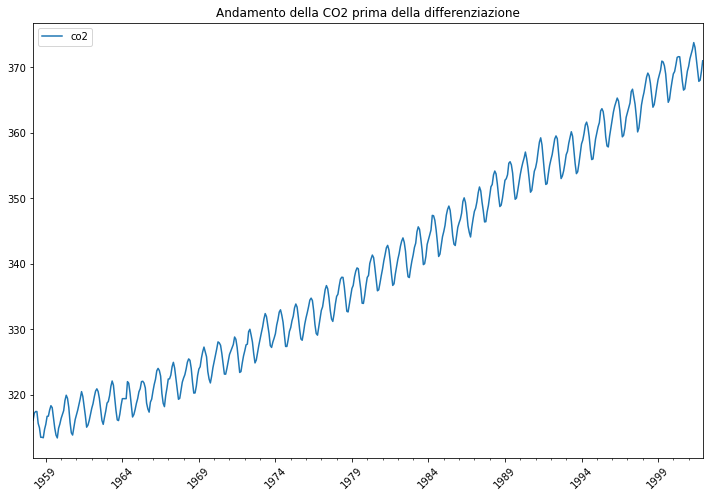

In [4]:
data = data.resample('M').mean()
data.plot(
    title='Andamento della CO2 prima della differenziazione', rot=45, figsize=(12,8))
plt.show()

A questo punto, possiamo effettuare la decomposizione STL della nostra serie temporale. Per farlo, usiamo il metodo [`STL`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html).

Dato che abbiamo a disposizione un dataframe Pandas nel quale gli indici sono le date di rilevamento del valore della CO2, StatsModels sarà in grado di inferire automaticamente il periodo e la stagionalità dei dati. Se avessimo avuto un semplice array NumPy, avremmo dovuto specificare manualmente questi parametri.

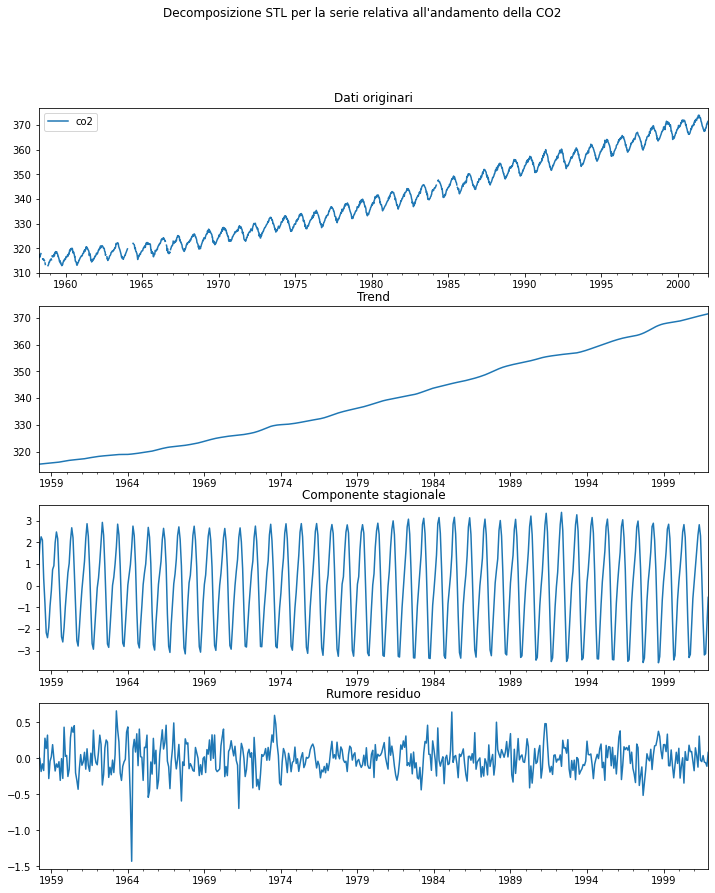

In [24]:
stl = STL(data)
res = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 14))
df.plot(ax=axes[0])
axes[0].set_title('Dati originari')
res.trend.plot(ax=axes[1])
axes[1].set_title('Trend')
res.seasonal.plot(ax=axes[2])
axes[2].set_title('Componente stagionale')
res.resid.plot(ax=axes[3])
axes[3].set_title('Rumore residuo')
plt.suptitle('Decomposizione STL per la serie relativa all\'andamento della CO2')
plt.show()

## Parte 2: modellazione con ARIMA

Vediamo adesso come cerare un modello per una serie temporale usando un ARIMA.

Per farlo, useremo un altro dataset, ovvero `sunspots`, relativo alla presenza di macchie solari sulla superficie del sole.

Iniziamo caricando il dataset, ed impostando come indice l'anno di rilevamento.

In [28]:
df = sunspots.load_pandas().data
df.set_index('YEAR', inplace=True)
df.head()

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0


Visualizziamo i dati.

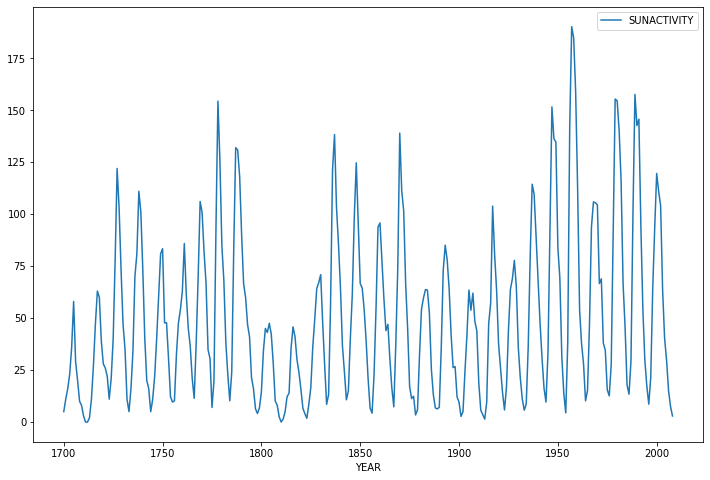

In [29]:
df.plot(figsize=(12, 8))
plt.show()

### Parte 2.1: determinare gli ordini AR, I ed MA

Per determinare gli ordini da utilizzare nel modello, possiamo usare due metodi:

1. effettuare un approccio *trial & error*, basandoci sui valori assunti da alcune metriche;
2. usare le funzioni di autocorrelazione (ACF) ed autocorrelazione parziale (PACF).

Nel primo caso, dovremo basarci sui valori assunti dalle metriche `AIC`, `BIC` ed `HQIC`, stanti rispettivamente per *Akaike Information Criterion*, *Bayesian Information Criterion* ed *Hannan-Quinn Information Criterion*. Trovate una descrizione più completa [a questo link](https://www.lorenzogovoni.com/selezione-del-modello-aic-bic-hqic/); tuttavia, basta sapere che, tra due modelli, si sceglie quello con i valori di AIC, BIC ed HQIC inferiori.

Nel secondo caso, invece, potremo fare uno studio qualitativo dell'andamento delle funzioni ACF e PACF, che ci aiuterà ad avere delle indicazioni sugli ordini da utilizzare. Proviamo ad usare il secondo aprroccio.

#### Parte 2.1.1: la funzione di autocorrelazione (ACF)

TODO: DA QUI

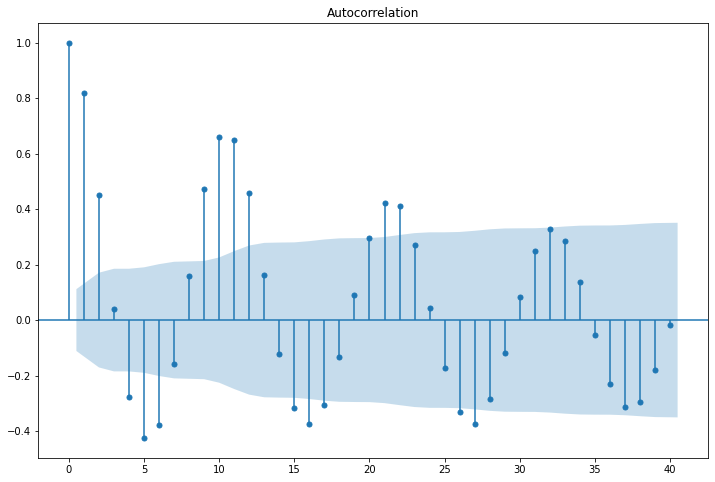

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax)
plt.show()

Se la serie fosse stazionaria, vedremmo ogni linea all'interno dell'intervallo di confidenza segnato in blu. Tuttavia, vediamo dei picchi e delle valli al di fuori di questo intervallo, ed un andamento veloce e decadente che ricorda un grafo. Questo indica che c'è una stagionalità, ma probabilmente non abbiamo alcun trend.

| Velocità decadimento | Similitudine ad un seno | Presenza trend | Presenza stagionalità |
| -------------------- | ----------------------- | -------------- | --------------------- |
| Lenta                | Sì                      | Sì             | Sì                    |
| Lenta                | No                      | Sì             | No                    |
| Rapida               | Sì                      | No             | Sì                    |

Abbiamo trascurato la stazionarietà: questa infatti c'è soltanto quando tutte le linee della funzione di autocorrelazione sono all'interno dell'intervallo di confidenza (ad eccezione della prima).

In questo caso, in base alla tabella precedente, possiamo supporre che vi sia una stagionalità, ma non un trend. Di conseguenza, l'impatto della parte MA dovrebbe essere giocoforza limitato sulle prestazioni del modello.

### Funzione di autocorrelazione parziale (PACF)

DEFINIZIONE

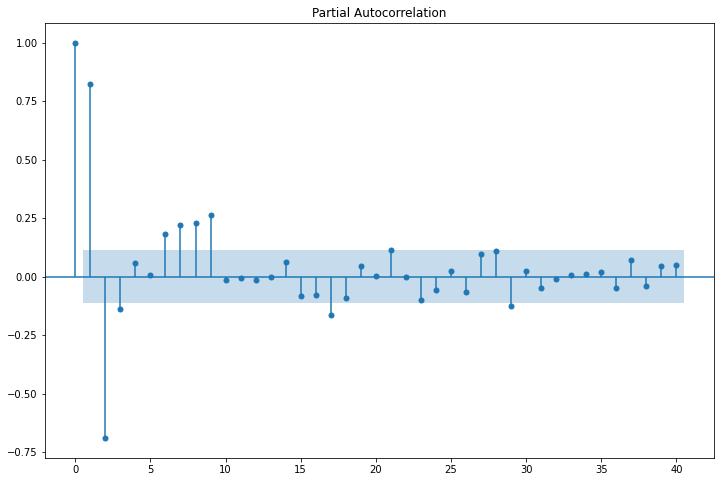

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax)
plt.show()

Quello che ci interessa individuare nella PACF sono i picchi e le valli che sono *significativamente* oltre l'intervallo di confidenza. In questo caso, ne notiamo due, ovvero quelli in posizione 1 e 2.

Questo ci permette di determinare un ordine per il nostro modello: proveremo, infatti, con AR = 2.

In [8]:
arma_mod20 = ARIMA(data, order=(2, 0, 0)).fit()
arma_mod20.summary()

c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1307.319
Date:                Sat, 24 Jul 2021   AIC                           2622.637
Time:                        18:19:25   BIC                           2637.570
Sample:                             0   HQIC                          2628.607
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7462      3.938     12.631      0.000      42.027      57.465
ar.L1          1.3906      0.037     37.694      0.000       1.318       1.463
ar.L2         -0.6886      0.036    -19.363      0.000      -0.758      -0.619
sigma2       274.7272     18.897     14.538      0.000     237.689     311.765
===================================================================================
Ljung-Box (L1) (Q):                   2.40   Jarque-Bera (JB):                80.38
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.83
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
arma_mod30 = ARIMA(data, order=(3, 0, 0)).fit()
arma_mod30.summary()

c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\acard\.virtualenvs\python-data-science-3i9dh0ed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1304.702
Date:                Sat, 24 Jul 2021   AIC                           2619.404
Time:                        18:19:25   BIC                           2638.070
Sample:                             0   HQIC                          2626.867
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7519      3.518     14.141      0.000      42.856      56.648
ar.L1          1.3008      0.050     25.763      0.000       1.202       1.400
ar.L2         -0.5081      0.079     -6.421      0.000      -0.663      -0.353
ar.L3         -0.1296      0.058     -2.236      0.025      -0.243      -0.016
sigma2       270.1011     18.599     14.523      0.000     233.649     306.554
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               105.66
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.92
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

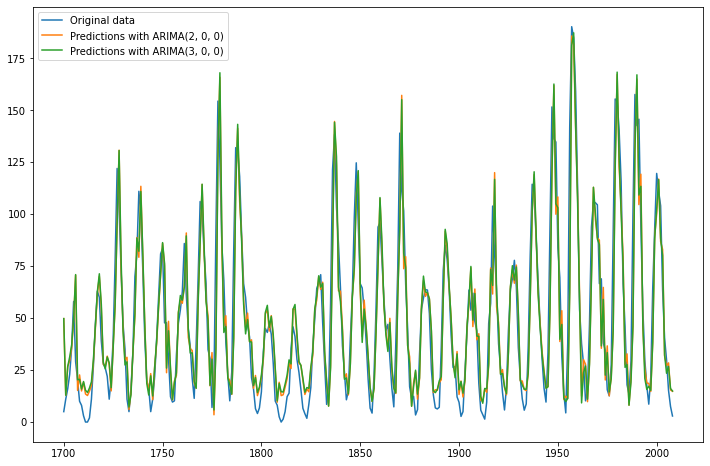

In [11]:
predictions = arma_mod20.predict()
preds = arma_mod30.predict()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(data, label='Original data')
ax.plot(predictions, label='Predictions with ARIMA(2, 0, 0)')
ax.plot(preds, label='Predictions with ARIMA(3, 0, 0)')
ax.legend()

plt.show()



## Esercizio

Provate ad effettuare la decomposizione STL sul dataset sunspots, e la modellazione con ARIMA sul dataset CO2.